In [1]:
#####################################################################
# This notebook is authored by: Ayan Paul                           #
# Date: November 2020                                               #
# If you use this code or the results from this work please cite:   # 
# Resurrecting bbh with kinematic shapes                            #
# Christophe Grojean, Ayan Paul and Zuoni Qian                      #
# arXiv:2011.13945 (https://arxiv.org/abs/2011.13945)               # 
#####################################################################

import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import ensemble
import sklearn.model_selection as ms
from sklearn import metrics
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math as m
import collections
import pickle
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from colour import Color
from matplotlib import rc
import sys
from xgboost import plot_tree


# To supress warnings from shap
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
N_THREADS = 88 ## Change for reducing load on CPU
os.environ['OMP_NUM_THREADS'] = str(N_THREADS)
seed = 42

colors = ['#3f7f93','#da3b46']
cmp_2 = LinearSegmentedColormap.from_list('my_list', [Color(c1).rgb for c1 in colors], N=2)

colors = [ '#E4B4C2','#3f7f93','#9448BC','#F6AE2D','#da3b46']
cmp_5 = LinearSegmentedColormap.from_list('my_list', [Color(c1).rgb for c1 in colors], N=5)

## Helper funtion for I/O, BDT analysis and evaluation of results

In [2]:
def fileparser(path, dlist, frac=0.5, sample=0, L=2):
    """ The fileparser to read the events from a csv
        argument:
            path: the path to the file
            dlist: the list of variables to be excluded
            frac: the fraction of sample that will be the test sample when sample is set to 0
            sample: the number of events that will be the train sample.
            L: Luminosity scaling
        returns:
            df_train: the training dataframe
            df_test: the testing dataframe
            weight: the weight (related to crosssection)
    """
    df = pd.read_csv(path)
    df.drop(columns=dlist, inplace=True)    
    n = len(df)
    weight = int(round(np.abs(df['weight'].sum()) * 3. * 1e6 * L)) ## The abs(mean()) is taken to make the weight of ybyt +ve
    df['weight'] = df['weight']/np.abs(df['weight'])
    if sample != 0:
        df_train = df.sample(n=sample, random_state=seed)
        df_test = df.drop(df_train.index)
    else :
        df_test = df.sample(frac=frac, random_state=seed)
        df_train = df.drop(df_test.index)
    return df_train, df_test, weight

def runBDT(df, filename='', rf=False, depth=10, sample=1, seed=seed):
    """ The BDT/RF runner
        argument:
            df: the dataframe with all the events
            filename: the name of the pickle file to store the model in
            rf: a bolean to toggle between BDT and Random Forest classifiers
            sample: The fraction of variables to sample
            seed: the seed for the random number generator
        returns:
            classifier: the classifier
            x_test: the features for the test set
            y_test: the labels for the test set
            shap_values: the SHAP values
            X_shap: the feature set with which the shap values have been computed
    """
    mshap = False if depth <= 10 else False
    df = df.sample(frac=sample)
    X = df.drop(columns=['class', 'weight'])
    y = df['class'].values

    # Split for training and testing
    x_train, x_test, y_train, y_test = ms.train_test_split(X.values, y, test_size=0.2, random_state=seed)
    eval_set = [(x_train, y_train), (x_test, y_test)]
    
    # Fit the decision tree
    if rf: 
        classifier = ensemble.RandomForestClassifier(max_depth=depth, n_estimators=1000, criterion='gini', n_jobs=int(N_THREADS/2), random_state=seed)
        classifier = classifier.fit(x_train, y_train)
    else: 
        classifier = xgb.XGBClassifier(max_depth=depth, learning_rate=0.01, objective='multi:softprob', num_class=nchannels,
                                         nthread=N_THREADS, subsample=0.5, colsample_bytree=1, n_estimators=5, random_state=seed)
        classifier = classifier.fit(x_train, y_train, early_stopping_rounds=50, eval_set=eval_set,
                                eval_metric=["merror", "mlogloss"], verbose=False)
    
    # Predictions
    y_pred = classifier.predict(x_test)
    print('Accuracy Score: {:4.2f}% '.format(100*metrics.accuracy_score(y_test, y_pred)))
    if filename != '': pickle.dump(classifier, open(filename, 'wb'))
    
    # Calculate the SHAP scores
    if mshap:
        X_shap = pd.DataFrame(x_test, columns=df.drop(columns=['class', 'weight']).columns)
        explainer = shap.TreeExplainer(classifier)
        shap_values = explainer.shap_values(X_shap)
        return classifier, x_test, y_test, shap_values, X_shap
        
    else: return classifier, x_test, y_test

def eval_training(classifier):
    """ Evaluate the training
        argument:
            classifier: the BDT classifier
    """
    results = classifier.evals_result()
    epochs = len(results['validation_0']['merror'])
    x_axis = range(0, epochs)

    # plot log loss
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(x_axis, results['validation_0']['mlogloss'], label='train')
    plt.plot(x_axis, results['validation_1']['mlogloss'], label='test')
    plt.legend()

    plt.ylabel('log loss')
    plt.title('Classifier log loss')
    plt.grid()

    # plot classification error
    plt.subplot(1, 2, 2)
    plt.plot(x_axis, results['validation_0']['merror'], label='train')
    plt.plot(x_axis, results['validation_1']['merror'], label='test')
    plt.legend()

    plt.ylabel('Classification Error')
    plt.title('Classification Error')
    plt.grid()
    plt.show()
    
def get_mclass(i, df_array, weight_array, ps_exp_class, seed=seed):
    """ This function is used to create the confusion matrix
        arguments:
            i: integer corresponding to the class number
            df_array: the array of the dataframes of the different classes
            weight_array: the array of the weights for the different classes
            ps_exp_class: the collection of the pseudo experiment events
            seed: the seed for the random number generator
        returns:
            nevents: the number of events
            sif: the significance
    """
    mclass = []
    for j in range(nchannels):
        mclass.append(collections.Counter(classifier.predict(df_array[j].iloc[:,:-2].values))[i]/len(df_array[j])*weight_array[j]/weight_array[i])

    sig = np.sqrt(ps_exp_class[i])*mclass[i]/np.sum(mclass)
    nevents = np.round(ps_exp_class[i]/np.sum(mclass)*np.array(mclass)).astype(int)
    print('sig: {:2.2f}, yb2 events: {}, ybyt events: {}, yt2 events: {}, zh events: {}, bbxaa events: {}'.format(sig, nevents[4], nevents[3], nevents[2], nevents[1], nevents[0]))
    return nevents, sig 


def abs_shap(df_shap, df, shap_plot, names, class_names, cmp):
    ''' A function to plot the bar plot for the mean abs SHAP values
        arguments:
            df_shap: the dataframe of the SHAP values
            df: the dataframe for the feature values for which the SHAP values have been determined
            shap_plot: The name of the output file for the plot
            names: The names of the variables
            class_names: names of the classes
            cmp: the colour map
    '''
    rc('text', usetex=True)
    plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"
    plt.figure(figsize=(5,5))
    shap.summary_plot(df_shap, df, color=cmp, class_names=class_names, class_inds='original', plot_size=(5,5), show=False, feature_names=names)
    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='lower right', fontsize=15)
    plt.xlabel(r'$\overline{|S_v|}$', fontsize=15)
    ax = plt.gca()
    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)
    ax.spines["left"].set_visible(True)
    vals = ax.get_xticks()
    ax.tick_params(axis='both', which='major', labelsize=15)
    for tick in vals:
        ax.axvline(x=tick, linestyle='dashed', alpha=0.7, color='#808080', zorder=0, linewidth=0.5)
    plt.tight_layout()
    plt.savefig(shap_plot, dpi=300)
    rc('text', usetex=False)
    
#define a function to convert logodds to probability for multi-class 
def logodds_to_proba(logodds):
    return np.exp(logodds)/np.exp(logodds).sum()

## 14 TeV Analysis

### Load the data

In [3]:
dlist = ['dphibb', 'etaaa', 'ptb2', 'drbamin', 'met', 'etaa2', 'etab1', 'etaa1', 'nbjet', 'etab2']
names = [r'$n_{jet}$', r'$p_T^{b_1}$', r'$p_T^{\gamma_1}$', r'$p_T^{\gamma_2}$', r'$p_T^{\gamma\gamma}$', r'$m_{bb}$', r'$m_{\gamma\gamma}$', r'$m_{b_1h}$', r'$m_{bbh}$',
           r'$H_T$', r'$\delta R_{b\gamma_1}$', r'$\delta\phi_{b\gamma_1}$']
# dlist = []
# names = [r'$n_{b-jet}$', r'$n_{jet}$', r'$p_T^{b_1}$', r'$p_T^{b_2}$', r'$p_T^{\gamma_1}$', r'$p_T^{\gamma_2}$', r'$p_T^{\gamma\gamma}$', r'$\eta_{b1}$', r'$\eta_{b2}$', 
#          r'$\eta_{\gamma_1}$', r'$\eta_{\gamma_2}$', r'$\eta_{\gamma\gamma}$', r'$m_{bb}$', r'$m_{\gamma\gamma}$', r'$m_{b_1h}$', r'$m_{bbh}$', r'$E_T^{\rm miss}$',
#            r'$H_T$', r'$\delta R_{b\gamma_1}$', r'$\delta\phi_{b\gamma_1}$', r'$\delta\phi_{bb}$']

# 14 TeV
df_yb2, df_yb2_test, weight_yb2 = fileparser("../simulations/HL-LHC/yb2.csv", dlist, sample=20000)
df_ybyt, df_ybyt_test, weight_ybyt = fileparser("../simulations/HL-LHC/ybyt.csv", dlist, sample=20000)
df_yt2, df_yt2_test, weight_yt2 = fileparser("../simulations/HL-LHC/yt2.csv", dlist, sample=20000)
df_zh, df_zh_test, weight_zh = fileparser("../simulations/HL-LHC/zh.csv", dlist, sample=40000)
df_bbxaa, df_bbxaa_test, weight_bbxaa = fileparser("../simulations/HL-LHC/bbxaa.csv", dlist, sample=100000)

print("No. of yb2 events: train = {}, test = {}".format(df_yb2.shape[0],df_yb2_test.shape[0]))
print("No. of ybyt events: train = {}, test = {}".format(df_ybyt.shape[0],df_ybyt_test.shape[0]))
print("No. of yt2 events: train = {}, test = {}".format(df_yt2.shape[0],df_yt2_test.shape[0]))
print("No. of zh events: train = {}, test = {}".format(df_zh.shape[0],df_zh_test.shape[0]))
print("No. of bbxaa events: train = {}, test = {}".format(df_bbxaa.shape[0],df_bbxaa_test.shape[0]))

No. of yb2 events: train = 20000, test = 26740
No. of ybyt events: train = 20000, test = 18341
No. of yt2 events: train = 20000, test = 81774
No. of zh events: train = 40000, test = 139021
No. of bbxaa events: train = 100000, test = 37488


## The Zh vs. yb2 analysis

- Add the two datasets
- Run the BDT and make the SHAP plot
- Check the accuracy of the classifier
- make the discriminator plot

In [4]:
channels = [df_yb2, df_zh]
nchannels = len(channels)
df_train = pd.concat(channels, ignore_index=True)
df_train = df_train.sample(frac=1).reset_index(drop=True)

Accuracy Score: 79.88% 


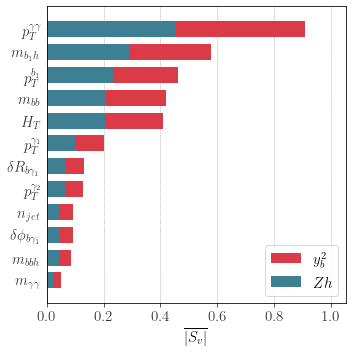

In [5]:
class_names = [r'$Zh$', r'$y_b^2$']
filename = 'models/HL-LHC-BDT/hbb-BDT-2class-bg-1b-met-ht-btag.pickle.dat' ## The pickle model store if necessary.
shap_plot = '../plots/shap-zh-yb2.pdf'

classifier, x_test, y_test, shap_values_2, X_shap_2 = runBDT(df_train, filename)
abs_shap(shap_values_2, X_shap_2, shap_plot, names=names, class_names=class_names, cmp=cmp_2)

In [6]:
classifier = pickle.load(open('models/HL-LHC-BDT/hbb-BDT-2class-bg-1b-met-ht-btag.pickle.dat', 'rb')) ## If model is stored
comb_test = pd.concat([df_yb2_test.iloc[:,:-1].sample(n=20000, random_state=seed), df_zh_test.iloc[:,:-1].sample(n=20000, random_state=seed)])
print('Accuracy Score: {:4.2f}% '.format(100*metrics.accuracy_score(comb_test['class'].values, classifier.predict(comb_test.drop(columns=['class']).values))))

Accuracy Score: 74.30% 


Accuracy Score for yb2: 57.68% 
Accuracy Score for zh: 90.97% 


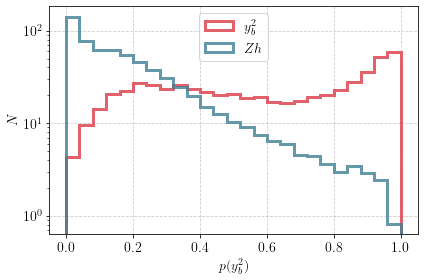

In [7]:
disc = 1
enc=100
yb2_p = pd.DataFrame(classifier.predict_proba(df_yb2_test.drop(columns=['class', 'weight']).values)[:,disc])
print('Accuracy Score for yb2: {:4.2f}% '.format(100*metrics.accuracy_score(df_yb2_test['class'].values, classifier.predict(df_yb2_test.drop(columns=['class', 'weight']).values))))
yb2_p['weight'] = df_yb2_test['weight'].values

zh_p = pd.DataFrame(classifier.predict_proba(df_zh_test.drop(columns=['class', 'weight']).values)[:,disc])
print('Accuracy Score for zh: {:4.2f}% '.format(100*metrics.accuracy_score(df_zh_test['class'].values, classifier.predict(df_zh_test.drop(columns=['class', 'weight']).values))))
zh_p['weight'] = df_zh_test['weight'].values

yb2_pred = yb2_p.sample(n=round(weight_yb2*1.5*enc), replace=True, random_state=seed).reset_index(drop=True)
zh_pred = zh_p.sample(n=round(weight_zh*1.3*enc), replace=True, random_state=seed).reset_index(drop=True)

plt.figure(figsize=(6,4))
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]
sns.distplot(yb2_pred[0], kde=False, bins=np.arange(0, 1 + 0.04, 0.04),
             hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3, 'weights': [1/enc]*len(yb2_pred[0])}, label=r'$y_b^2$', color='#da3b46')
sns.distplot(zh_pred[0], kde=False, bins=np.arange(0, 1 + 0.04, 0.04),
             hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3, 'weights': [1/enc]*len(zh_pred[0])}, label=r'$Zh$', color='#3f7f93')
plt.legend(loc='upper center', fontsize=14)
plt.grid(linestyle='dashed', alpha=0.4, color='#808080')
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel(r'$p(y_b^2)$', fontsize=14)
plt.ylabel(r'$N$', fontsize=14)
plt.yscale('log')
plt.tight_layout()
plt.savefig('../plots/zh-yb2-BDT-dist.pdf', dpi=300)

## The yt2 vs. yb2 analysis

- Add the two datasets
- Run the BDT and make the SHAP plot
- Check the accuracy of the classifier
- make the discriminator plot

In [8]:
channels = [df_yb2, df_yt2]
nchannels = len(channels)
df_train = pd.concat(channels, ignore_index=True)
df_train = df_train.sample(frac=1).reset_index(drop=True)

Accuracy Score: 67.92% 


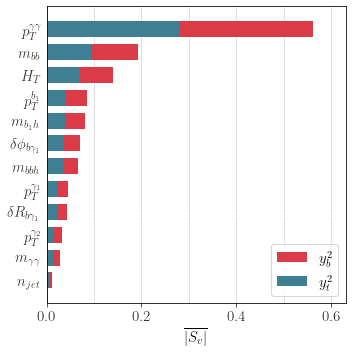

In [9]:
class_names = [r'$y_t^2$', r'$y_b^2$']
filename = 'models/HL-LHC-BDT/hbb-BDT-2class-yb2-yt2-bg-1b-met-ht-btag.pickle.dat' ## The pickle model store if necessary.
shap_plot = '../plots/shap-yt2-yb2.pdf'

classifier, x_test, y_test, shap_values_2, X_shap_2 = runBDT(df_train, filename)
abs_shap(shap_values_2, X_shap_2, shap_plot, names=names, class_names=class_names, cmp=cmp_2)

In [10]:
classifier = pickle.load(open('models/HL-LHC-BDT/hbb-BDT-2class-yb2-yt2-bg-1b-met-ht-btag.pickle.dat', 'rb')) ## If model is stored
comb_test = pd.concat([df_yb2_test.iloc[:,:-1].sample(n=20000, random_state=seed), df_yt2_test.iloc[:,:-1].sample(n=20000, random_state=seed)])
print('Accuracy Score: {:4.2f}% '.format(100*metrics.accuracy_score(comb_test['class'].values, classifier.predict(comb_test.drop(columns=['class']).values))))

Accuracy Score: 68.22% 


Accuracy Score for yb2: 73.51% 
Accuracy Score for yt2: 63.30% 


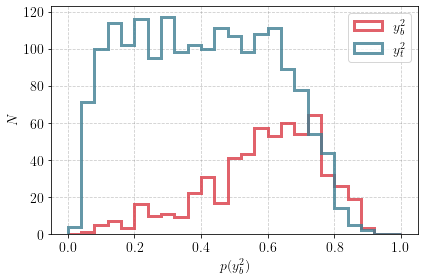

In [11]:
disc = 1
enc=1
yb2_p = pd.DataFrame(classifier.predict_proba(df_yb2_test.drop(columns=['class', 'weight']).values)[:,disc])
print('Accuracy Score for yb2: {:4.2f}% '.format(100*metrics.accuracy_score(df_yb2_test['class'].values, classifier.predict(df_yb2_test.drop(columns=['class', 'weight']).values))))
yb2_p['weight'] = df_yb2_test['weight'].values

yt2_p = pd.DataFrame(classifier.predict_proba(df_yt2_test.drop(columns=['class', 'weight']).values)[:,disc])
print('Accuracy Score for yt2: {:4.2f}% '.format(100*metrics.accuracy_score(df_yt2_test['class'].values, classifier.predict(df_yt2_test.drop(columns=['class', 'weight']).values))))
yt2_p['weight'] = df_yt2_test['weight'].values

yb2_pred = yb2_p.sample(n=round(weight_yb2*1.5*enc), replace=True, random_state=seed).reset_index(drop=True)
yt2_pred = yt2_p.sample(n=round(weight_yt2*2.5*enc), replace=True, random_state=seed).reset_index(drop=True)

plt.figure(figsize=(6,4))
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]
sns.distplot(yb2_pred[0], kde=False, bins=np.arange(0, 1 + 0.04, 0.04),
             hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3, 'weights': [1/enc]*len(yb2_pred[0])}, label=r'$y_b^2$', color='#da3b46')
sns.distplot(yt2_pred[0], kde=False, bins=np.arange(0, 1 + 0.04, 0.04),
             hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3, 'weights': [1/enc]*len(yt2_pred[0])}, label=r'$y_t^2$', color='#3f7f93')
plt.legend(loc='upper right', fontsize=14)
plt.grid(linestyle='dashed', alpha=0.4, color='#808080')
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel(r'$p(y_b^2)$', fontsize=14)
plt.ylabel(r'$N$', fontsize=14)
# plt.yscale('log')
plt.tight_layout()
plt.savefig('../plots/yt2-yb2-BDT-dist.pdf', dpi=300)

## The 5 class classfication

- Add the five datasets
- Run the BDT and make the SHAP plot
- Check the accuracy of the classifier
- make the discriminator plot
- Build the confusions matrix by doing the following
    - build the confusion matrix for the positive and negative weights of ybyt separately
    - combine the two to get the confusion matrix

In [4]:
channels = [df_yb2, df_ybyt, df_yt2, df_zh, df_bbxaa]
nchannels = len(channels)
df_train = pd.concat(channels, ignore_index=True)
df_train = df_train.sample(frac=1).reset_index(drop=True)

# Special treatment for ybyt
df_tmp = pd.read_csv("../simulations/HL-LHC/ybyt.csv")
ybyt_ratio = df_tmp[df_tmp['weight']<0].shape[0]/df_tmp[df_tmp['weight']>0].shape[0]

### Run this cell only if you want to rerun the classifier

In [17]:
class_names = [r'$bb\gamma\gamma$', r'$Zh$', r'$y_t^2$', r'$y_by_t$', r'$y_b^2$']
filename = 'models/HL-LHC-BDT/hbb-BDT-multiclass-bg-1b-met-ht-btag.pickle.dat' ## The pickle model store if necessary.
shap_plot = '../plots/shap-5.pdf'

# classifier, x_test, y_test, shap_values_5, X_shap_5 = runBDT(df_train, filename, depth=3)
classifier, x_test, y_test = runBDT(df_train, filename, depth=3)
# abs_shap(shap_values_5, X_shap_5, shap_plot, names=names, class_names=class_names, cmp=cmp_5)

Accuracy Score: 56.02% 


#### Load the Classifier and run the analysis. The Accuracy is measured with eqisized samples

In [57]:
classifier = pickle.load(open('models/HL-LHC-BDT/hbb-BDT-multiclass-bg-1b-met-ht-btag.pickle.dat', 'rb')) ## If model is stored
comb_test = pd.concat([df_yb2_test.iloc[:,:-1].sample(n=10000, random_state=seed), df_ybyt_test.iloc[:,:-1].sample(n=10000, random_state=seed),
                       df_yt2_test.iloc[:,:-1].sample(n=10000, random_state=seed), df_zh_test.iloc[:,:-1].sample(n=10000, random_state=seed),
                       df_bbxaa_test.iloc[:,:-1].sample(n=10000, random_state=seed)])
print('Accuracy Score: {:4.2f}% '.format(100*metrics.accuracy_score(comb_test['class'].values, classifier.predict(comb_test.drop(columns=['class']).values))))

Accuracy Score: 32.65% 


In [62]:
df_train.keys()

Index(['njjet', 'ptb1', 'pta1', 'pta2', 'ptaa', 'mbb', 'maa', 'mb1h', 'mbbh',
       'ht', 'drba1', 'dphiba1', 'class', 'weight'],
      dtype='object')

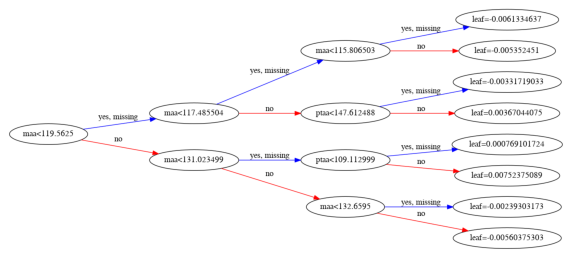

In [22]:
plt.figure(figsize=(10,10))
ax = plt.gca()
plot_tree(classifier, ax=ax, fmap='fmap.txt', rankdir='LR', num_trees=1)
# xgb.to_graphviz(classifier, ax=ax, fmap='fmap.txt')
fig = plt.gcf()
# fig.set_size_inches(10, 20)
plt.savefig('tree.png', dpi=300)
plt.show()

#### Check the accuracy of each sample and display the classification plot

Accuracy Score for yb2: 28.25% 
Accuracy Score for ybyt: 21.02% 
Accuracy Score for yt2: 25.49% 
Accuracy Score for zh: 63.97% 
Accuracy Score for bbxaa: 87.85% 


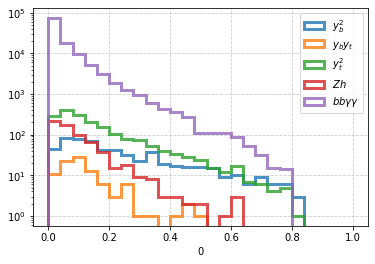

In [15]:
disc = 4
yb2_p = pd.DataFrame(classifier.predict_proba(df_yb2_test.drop(columns=['class', 'weight']).values)[:,disc])
print('Accuracy Score for yb2: {:4.2f}% '.format(100*metrics.accuracy_score(df_yb2_test['class'].values, classifier.predict(df_yb2_test.drop(columns=['class', 'weight']).values))))
yb2_p['weight'] = df_yb2_test['weight'].values

ybyt_p = pd.DataFrame(classifier.predict_proba(df_ybyt_test.drop(columns=['class', 'weight']).values)[:,disc])
print('Accuracy Score for ybyt: {:4.2f}% '.format(100*metrics.accuracy_score(df_ybyt_test['class'].values, classifier.predict(df_ybyt_test.drop(columns=['class', 'weight']).values))))
ybyt_p['weight'] = df_ybyt_test['weight'].values

yt2_p = pd.DataFrame(classifier.predict_proba(df_yt2_test.drop(columns=['class', 'weight']).values)[:,disc])
print('Accuracy Score for yt2: {:4.2f}% '.format(100*metrics.accuracy_score(df_yt2_test['class'].values, classifier.predict(df_yt2_test.drop(columns=['class', 'weight']).values))))
yt2_p['weight'] = df_yt2_test['weight'].values

zh_p = pd.DataFrame(classifier.predict_proba(df_zh_test.drop(columns=['class', 'weight']).values)[:,disc])
print('Accuracy Score for zh: {:4.2f}% '.format(100*metrics.accuracy_score(df_zh_test['class'].values, classifier.predict(df_zh_test.drop(columns=['class', 'weight']).values))))
zh_p['weight'] = df_zh_test['weight'].values

bbxaa_p = pd.DataFrame(classifier.predict_proba(df_bbxaa_test.drop(columns=['class', 'weight']).values)[:,disc])
print('Accuracy Score for bbxaa: {:4.2f}% '.format(100*metrics.accuracy_score(df_bbxaa_test['class'].values, classifier.predict(df_bbxaa_test.drop(columns=['class', 'weight']).values))))
bbxaa_p['weight'] = df_bbxaa_test['weight'].values

yb2_pred = yb2_p.sample(n=round(weight_yb2*1.5), replace=True, random_state=seed).reset_index(drop=True)
ybyt_pred = ybyt_p.sample(n=round(weight_ybyt*1.9), replace=True, random_state=seed).reset_index(drop=True)
yt2_pred = yt2_p.sample(n=round(weight_yt2*2.5), replace=True, random_state=seed).reset_index(drop=True)
zh_pred = zh_p.sample(n=round(weight_zh*1.3), replace=True, random_state=seed).reset_index(drop=True)
bbxaa_pred = bbxaa_p.sample(n=round(weight_bbxaa*1.5), replace=True, random_state=seed).reset_index(drop=True)

plt.figure(figsize=(6,4))
sns.distplot(yb2_pred[0], kde=False, bins=np.arange(0, 1 + 0.04, 0.04), hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3}, label=r'$y_b^2$')
sns.distplot(ybyt_pred[0], kde=False, bins=np.arange(0, 1 + 0.04, 0.04), hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3}, label=r'$y_by_t$')
sns.distplot(yt2_pred[0], kde=False, bins=np.arange(0, 1 + 0.04, 0.04), hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3}, label=r'$y_t^2$')
sns.distplot(zh_pred[0], kde=False, bins=np.arange(0, 1 + 0.04, 0.04), hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3}, label=r'$Zh$')
sns.distplot(bbxaa_pred[0], kde=False, bins=np.arange(0, 1 + 0.04, 0.04), hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3}, label=r'$bb\gamma\gamma$')
plt.legend()
plt.grid(linestyle='dashed', alpha=0.4, color='#808080')
plt.yscale('log')

#### Since ybyt has both positive and negative weights the confusion matrix has to be created separately for each

In [16]:
df_array = [df_bbxaa_test, df_zh_test, df_yt2_test, df_ybyt_test, df_yb2_test]
weight_array = [weight_bbxaa*1.5, weight_zh*1.3, weight_yt2*2.5, weight_ybyt*1.9, weight_yb2*1.5]

ps_exp_class = collections.Counter(classifier.predict(pd.concat([df_array[4].iloc[:,:-2].sample(n=round(weight_array[4]), random_state=seed), 
                                                                     df_array[3].iloc[:,:-2].sample(n=round(weight_array[3]), random_state=seed), 
                                                                     df_array[2].iloc[:,:-2].sample(n=round(weight_array[2]), random_state=seed), 
                                                                     df_array[1].iloc[:,:-2].sample(n=round(weight_array[1]), random_state=seed),
                                                                     df_array[0].iloc[:,:-2].sample(n=round(weight_array[0]), random_state=seed, replace=True)]).values))

nevents_yb2, sig_yb2 = get_mclass(4, df_array, weight_array, ps_exp_class)
nevents_ybyt, sig_ybyt = get_mclass(3, df_array, weight_array, ps_exp_class)
nevents_yt2, sig_yt2 = get_mclass(2, df_array, weight_array, ps_exp_class)
nevents_zh, sig_zh = get_mclass(1, df_array, weight_array, ps_exp_class)
nevents_bbxaa, sig_bbxaa = get_mclass(0, df_array, weight_array, ps_exp_class)
confusion = np.column_stack((nevents_yb2, nevents_ybyt, nevents_yt2, nevents_zh, nevents_bbxaa))

sig: 3.22, yb2 events: 163, ybyt events: 5, yt2 events: 226, zh events: 21, bbxaa events: 2143
sig: 0.39, yb2 events: 55, ybyt events: 20, yt2 events: 112, zh events: 28, bbxaa events: 2395
sig: 10.44, yb2 events: 53, ybyt events: 4, yt2 events: 467, zh events: 22, bbxaa events: 1454
sig: 4.32, yb2 events: 121, ybyt events: 24, yt2 events: 542, zh events: 413, bbxaa events: 8047
sig: 317.62, yb2 events: 189, ybyt events: 41, yt2 events: 489, zh events: 161, bbxaa events: 101758


In [17]:
df_ybyt_test_pos = df_ybyt_test[df_ybyt_test['weight']==1]
df_array = [df_bbxaa_test, df_zh_test, df_yt2_test, df_ybyt_test_pos, df_yb2_test]
weight_array = [weight_bbxaa*1.5, weight_zh*1.3, weight_yt2*2.5, (1./(ybyt_ratio-1.))*weight_ybyt*1.9, weight_yb2*1.5]

ps_exp_class_pos = collections.Counter(classifier.predict(pd.concat([df_array[4].iloc[:,:-2].sample(n=round(weight_array[4]), random_state=seed), 
                                                                     df_array[3].iloc[:,:-2].sample(n=round(weight_array[3]), random_state=seed), 
                                                                     df_array[2].iloc[:,:-2].sample(n=round(weight_array[2]), random_state=seed), 
                                                                     df_array[1].iloc[:,:-2].sample(n=round(weight_array[1]), random_state=seed),
                                                                     df_array[0].iloc[:,:-2].sample(n=round(weight_array[0]), random_state=seed, replace=True)]).values))

nevents_yb2, sig_yb2 = get_mclass(4, df_array, weight_array, ps_exp_class)
nevents_ybyt, sig_ybyt = get_mclass(3, df_array, weight_array, ps_exp_class)
nevents_yt2, sig_yt2 = get_mclass(2, df_array, weight_array, ps_exp_class)
nevents_zh, sig_zh = get_mclass(1, df_array, weight_array, ps_exp_class)
nevents_bbxaa, sig_bbxaa = get_mclass(0, df_array, weight_array, ps_exp_class)
confusion_pos = np.column_stack((nevents_yb2, nevents_ybyt, nevents_yt2, nevents_zh, nevents_bbxaa))

sig: 3.23, yb2 events: 163, ybyt events: 3, yt2 events: 226, zh events: 21, bbxaa events: 2146
sig: 0.20, yb2 events: 55, ybyt events: 10, yt2 events: 112, zh events: 28, bbxaa events: 2404
sig: 10.45, yb2 events: 53, ybyt events: 2, yt2 events: 467, zh events: 22, bbxaa events: 1455
sig: 4.32, yb2 events: 121, ybyt events: 18, yt2 events: 543, zh events: 413, bbxaa events: 8053
sig: 317.67, yb2 events: 189, ybyt events: 27, yt2 events: 489, zh events: 161, bbxaa events: 101772


In [18]:
df_ybyt_test_neg = df_ybyt_test[df_ybyt_test['weight']==-1]
df_array = [df_bbxaa_test, df_zh_test, df_yt2_test, df_ybyt_test_neg, df_yb2_test]
weight_array = [weight_bbxaa*1.5, weight_zh*1.3, weight_yt2*2.5, (ybyt_ratio/(ybyt_ratio-1.))*weight_ybyt*1.9, weight_yb2*1.5]

ps_exp_class_pos = collections.Counter(classifier.predict(pd.concat([df_array[4].iloc[:,:-2].sample(n=round(weight_array[4]), random_state=seed), 
                                                                     df_array[3].iloc[:,:-2].sample(n=round(weight_array[3]), random_state=seed), 
                                                                     df_array[2].iloc[:,:-2].sample(n=round(weight_array[2]), random_state=seed), 
                                                                     df_array[1].iloc[:,:-2].sample(n=round(weight_array[1]), random_state=seed),
                                                                     df_array[0].iloc[:,:-2].sample(n=round(weight_array[0]), random_state=seed, replace=True)]).values))

nevents_yb2, sig_yb2 = get_mclass(4, df_array, weight_array, ps_exp_class)
nevents_ybyt, sig_ybyt = get_mclass(3, df_array, weight_array, ps_exp_class)
nevents_yt2, sig_yt2 = get_mclass(2, df_array, weight_array, ps_exp_class)
nevents_zh, sig_zh = get_mclass(1, df_array, weight_array, ps_exp_class)
nevents_bbxaa, sig_bbxaa = get_mclass(0, df_array, weight_array, ps_exp_class)
confusion_neg = np.column_stack((nevents_yb2, nevents_ybyt, nevents_yt2, nevents_zh, nevents_bbxaa))

sig: 3.22, yb2 events: 163, ybyt events: 9, yt2 events: 225, zh events: 21, bbxaa events: 2140
sig: 0.68, yb2 events: 54, ybyt events: 35, yt2 events: 111, zh events: 28, bbxaa events: 2381
sig: 10.42, yb2 events: 53, ybyt events: 7, yt2 events: 466, zh events: 22, bbxaa events: 1452
sig: 4.31, yb2 events: 121, ybyt events: 37, yt2 events: 541, zh events: 412, bbxaa events: 8036
sig: 317.55, yb2 events: 189, ybyt events: 67, yt2 events: 489, zh events: 161, bbxaa events: 101733


#### The Confusion Matrix, total events count for each channel and the signal significance

In [19]:
confusion_tot = np.round(np.array([confusion_pos[4]*0.5, confusion_pos[3], confusion_pos[2]*0.5, confusion_pos[1]*0.5, confusion_pos[0]*0.5])
        +np.array([confusion_neg[4]*0.5, -confusion_neg[3], confusion_neg[2]*0.5, confusion_neg[1]*0.5, confusion_neg[0]*0.5])).astype(int)
confusion_tot_tmp = confusion_tot
event_total = np.array([[np.sum(confusion_tot[i])] for i in range(confusion_tot.shape[0])])
significance = np.array([np.abs(confusion_tot[i,i])/np.sqrt(np.sum(confusion_tot[:,i])) for i in range(confusion_tot.shape[0])])
significance = np.append(significance, 0)
confusion_tab1 = np.append(confusion_tot_tmp, event_total, axis=1)
confusion_tab2 = np.vstack((confusion_tab1, significance))
    
df_conf = pd.DataFrame(confusion_tab2, [r'$y_b^2$', r'$y_by_t$', r'$y_t^2$', r'$Zh$', r'$bb\gamma\gamma$', r'$\sigma$'])
df_conf.columns = [r'$y_b^2$', r'$y_by_t$', r'$y_t^2$', r'$Zh$', r'$bb\gamma\gamma$', 'total']
print(df_conf.to_latex(escape=False))

\begin{tabular}{lrrrrrr}
\toprule
{} &      $y_b^2$ &     $y_by_t$ &      $y_t^2$ &         $Zh$ &  $bb\gamma\gamma$ &     total \\
\midrule
$y_b^2$          &   163.000000 &    54.000000 &    53.000000 &   121.000000 &        189.000000 &     580.0 \\
$y_by_t$         &    -6.000000 &   -25.000000 &    -5.000000 &   -19.000000 &        -40.000000 &     -95.0 \\
$y_t^2$          &   226.000000 &   112.000000 &   466.000000 &   542.000000 &        489.000000 &    1835.0 \\
$Zh$             &    21.000000 &    28.000000 &    22.000000 &   412.000000 &        161.000000 &     644.0 \\
$bb\gamma\gamma$ &  2143.000000 &  2392.000000 &  1454.000000 &  8044.000000 &     101752.000000 &  115785.0 \\
$\sigma$         &     3.229781 &     0.494009 &    10.446225 &     4.318934 &        317.740815 &       0.0 \\
\bottomrule
\end{tabular}



## 100 TeV Analysis

- Load the datasets
- Add the five datasets
- Run the BDT and make the SHAP plot
- Check the accuracy of the classifier
- make the discriminator plot
- Build the confusions matrix by doing the following
    - build the confusion matrix for the positive and negative weights of ybyt separately
    - combine the two to get the confusion matrix

In [20]:
dlist = ['dphibb', 'etaaa', 'ptb2', 'drbamin', 'met', 'etaa2', 'etab1', 'etaa1', 'nbjet', 'etab2']

# 100 TeV 
df_yb2_1, df_yb2_test_1, weight_yb2_1 = fileparser("../simulations/FCC-hh/yb2_1.csv", dlist, sample=10000, L=10)
df_yb2_2, df_yb2_test_2, weight_yb2_2 = fileparser("../simulations/FCC-hh/yb2_2.csv", dlist, sample=10000, L=10)
df_yb2 = pd.concat([df_yb2_1, df_yb2_2])
df_yb2_test = pd.concat([df_yb2_test_1, df_yb2_test_2])
weight_yb2 = int(np.max([weight_yb2_1, weight_yb2_2]))

df_ybyt_1, df_ybyt_test_1, weight_ybyt_1 = fileparser("../simulations/FCC-hh/ybyt_1.csv", dlist, sample=10000, L=10)
df_ybyt_2, df_ybyt_test_2, weight_ybyt_2 = fileparser("../simulations/FCC-hh/ybyt_2.csv", dlist, sample=10000, L=10)
df_ybyt = pd.concat([df_ybyt_1, df_ybyt_2])
df_ybyt_test = pd.concat([df_ybyt_test_1, df_ybyt_test_2])
weight_ybyt = int(np.max([weight_ybyt_1, weight_ybyt_2]))

df_yt2_1, df_yt2_test_1, weight_yt2_1 = fileparser("../simulations/FCC-hh/yt2_1.csv", dlist, sample=10000, L=10)
df_yt2_2, df_yt2_test_2, weight_yt2_2 = fileparser("../simulations/FCC-hh/yt2_2.csv", dlist, sample=10000, L=10)
df_yt2 = pd.concat([df_yt2_1, df_yt2_2])
df_yt2_test = pd.concat([df_yt2_test_1, df_yt2_test_2])
weight_yt2 = int(np.max([weight_yt2_1, weight_yt2_2]))

df_zh, df_zh_test, weight_zh = fileparser("../simulations/FCC-hh/zh.csv", dlist, sample=20000, L=10)

df_bbxaa_1, df_bbxaa_test_1, weight_bbxaa_1 = fileparser("../simulations/FCC-hh/bbxaa_1.csv", dlist, sample=50000, L=10)
df_bbxaa_2, df_bbxaa_test_2, weight_bbxaa_2 = fileparser("../simulations/FCC-hh/bbxaa_2.csv", dlist, sample=50000, L=10)
df_bbxaa = pd.concat([df_bbxaa_1, df_bbxaa_2])
df_bbxaa_test = pd.concat([df_bbxaa_test_1, df_bbxaa_test_2])
weight_bbxaa = int(np.max([weight_bbxaa_1, weight_bbxaa_2]))



print("No. of yb2 events: train = {}, test = {}".format(df_yb2.shape[0],df_yb2_test.shape[0]))
print("No. of ybyt events: train = {}, test = {}".format(df_ybyt.shape[0],df_ybyt_test.shape[0]))
print("No. of yt2 events: train = {}, test = {}".format(df_yt2.shape[0],df_yt2_test.shape[0]))
print("No. of zh events: train = {}, test = {}".format(df_zh.shape[0],df_zh_test.shape[0]))
print("No. of bbxaa events: train = {}, test = {}".format(df_bbxaa.shape[0],df_bbxaa_test.shape[0]))

No. of yb2 events: train = 20000, test = 144098
No. of ybyt events: train = 20000, test = 58586
No. of yt2 events: train = 20000, test = 274102
No. of zh events: train = 20000, test = 43525
No. of bbxaa events: train = 100000, test = 181650


In [21]:
channels = [df_yb2, df_ybyt, df_yt2, df_zh, df_bbxaa]
nchannels = len(channels)
df_train = pd.concat(channels, ignore_index=True)
df_train = df_train.sample(frac=1).reset_index(drop=True)

# Special treatment for ybyt
df_tmp_1 = pd.read_csv("../simulations/FCC-hh/ybyt_1.csv")
df_tmp_2 = pd.read_csv("../simulations/FCC-hh/ybyt_2.csv")
df_tmp = pd.concat([df_tmp_1, df_tmp_2])
ybyt_ratio = df_tmp[df_tmp['weight']<0].shape[0]/df_tmp[df_tmp['weight']>0].shape[0]

### Run this cell only if you want to rerun the classifier

Accuracy Score: 73.50% 


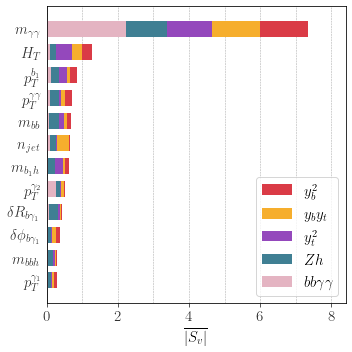

In [22]:
class_names = [r'$bb\gamma\gamma$', r'$Zh$', r'$y_t^2$', r'$y_by_t$', r'$y_b^2$']
filename = 'models/FCC-BDT/hbb-BDT-multiclass-bg-1b-met-ht-btag.pickle.dat' ## The pickle model store if necessary.
shap_plot = '../plots/shap-5-FCC.pdf'

classifier, x_test, y_test, shap_values_100, X_shap_100 = runBDT(df_train, filename)
abs_shap(shap_values_100, X_shap_100, shap_plot, names=names, class_names=class_names, cmp=cmp_5)

#### Load the Classifier and run the analysis. The Accuracy is measured with eqisized samples

In [23]:
classifier = pickle.load(open('models/FCC-BDT/hbb-BDT-multiclass-bg-1b-met-ht-btag.pickle.dat', 'rb'))  ## If model is stored
comb_test = pd.concat([df_yb2_test.iloc[:,:-1].sample(n=10000, random_state=seed), df_ybyt_test.iloc[:,:-1].sample(n=10000, random_state=seed),
                       df_yt2_test.iloc[:,:-1].sample(n=10000, random_state=seed), df_zh_test.iloc[:,:-1].sample(n=10000, random_state=seed),
                       df_bbxaa_test.iloc[:,:-1].sample(n=10000, random_state=seed)])
print('Accuracy Score: {:4.2f}% '.format(100*metrics.accuracy_score(comb_test['class'].values, classifier.predict(comb_test.drop(columns=['class']).values))))

Accuracy Score: 58.97% 


#### Check the accuracy of each sample and display the classification plot

Accuracy Score for yb2: 43.63% 
Accuracy Score for ybyt: 60.47% 
Accuracy Score for yt2: 47.52% 
Accuracy Score for zh: 53.24% 
Accuracy Score for bbxaa: 91.13% 


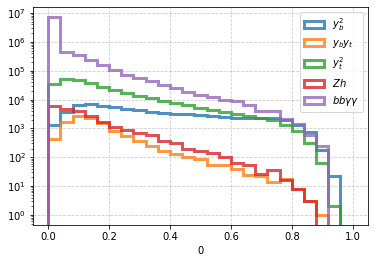

In [24]:
disc = 4
yb2_p = pd.DataFrame(classifier.predict_proba(df_yb2_test.drop(columns=['class', 'weight']).values)[:,disc])
print('Accuracy Score for yb2: {:4.2f}% '.format(100*metrics.accuracy_score(df_yb2_test['class'].values, classifier.predict(df_yb2_test.drop(columns=['class', 'weight']).values))))
yb2_p['weight'] = df_yb2_test['weight'].values

ybyt_p = pd.DataFrame(classifier.predict_proba(df_ybyt_test.drop(columns=['class', 'weight']).values)[:,disc])
print('Accuracy Score for ybyt: {:4.2f}% '.format(100*metrics.accuracy_score(df_ybyt_test['class'].values, classifier.predict(df_ybyt_test.drop(columns=['class', 'weight']).values))))
ybyt_p['weight'] = df_ybyt_test['weight'].values

yt2_p = pd.DataFrame(classifier.predict_proba(df_yt2_test.drop(columns=['class', 'weight']).values)[:,disc])
print('Accuracy Score for yt2: {:4.2f}% '.format(100*metrics.accuracy_score(df_yt2_test['class'].values, classifier.predict(df_yt2_test.drop(columns=['class', 'weight']).values))))
yt2_p['weight'] = df_yt2_test['weight'].values

zh_p = pd.DataFrame(classifier.predict_proba(df_zh_test.drop(columns=['class', 'weight']).values)[:,disc])
print('Accuracy Score for zh: {:4.2f}% '.format(100*metrics.accuracy_score(df_zh_test['class'].values, classifier.predict(df_zh_test.drop(columns=['class', 'weight']).values))))
zh_p['weight'] = df_zh_test['weight'].values

bbxaa_p = pd.DataFrame(classifier.predict_proba(df_bbxaa_test.drop(columns=['class', 'weight']).values)[:,disc])
print('Accuracy Score for bbxaa: {:4.2f}% '.format(100*metrics.accuracy_score(df_bbxaa_test['class'].values, classifier.predict(df_bbxaa_test.drop(columns=['class', 'weight']).values))))
bbxaa_p['weight'] = df_bbxaa_test['weight'].values

yb2_pred = yb2_p.sample(n=round(weight_yb2*1.5), replace=True, random_state=seed).reset_index(drop=True)
ybyt_pred = ybyt_p.sample(n=round(weight_ybyt*1.9), replace=True, random_state=seed).reset_index(drop=True)
yt2_pred = yt2_p.sample(n=round(weight_yt2*2.5), replace=True, random_state=seed).reset_index(drop=True)
zh_pred = zh_p.sample(n=round(weight_zh*1.3), replace=True, random_state=seed).reset_index(drop=True)
bbxaa_pred = bbxaa_p.sample(n=round(weight_bbxaa*1.5), replace=True, random_state=seed).reset_index(drop=True)

plt.figure(figsize=(6,4))
sns.distplot(yb2_pred[0], kde=False, bins=np.arange(0, 1 + 0.04, 0.04), hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3}, label=r'$y_b^2$')
sns.distplot(ybyt_pred[0], kde=False, bins=np.arange(0, 1 + 0.04, 0.04), hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3}, label=r'$y_by_t$')
sns.distplot(yt2_pred[0], kde=False, bins=np.arange(0, 1 + 0.04, 0.04), hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3}, label=r'$y_t^2$')
sns.distplot(zh_pred[0], kde=False, bins=np.arange(0, 1 + 0.04, 0.04), hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3}, label=r'$Zh$')
sns.distplot(bbxaa_pred[0], kde=False, bins=np.arange(0, 1 + 0.04, 0.04), hist_kws={'alpha': 0.8, 'histtype': 'step', 'linewidth': 3}, label=r'$bb\gamma\gamma$')
plt.legend()
plt.grid(linestyle='dashed', alpha=0.4, color='#808080')
plt.yscale('log')

#### Since ybyt has both positive and negative weights the confusion matrix has to be created separately for each

In [25]:
df_array = [df_bbxaa_test, df_zh_test, df_yt2_test, df_ybyt_test, df_yb2_test]
weight_array = [weight_bbxaa*1.5, weight_zh*1.3, weight_yt2*2.5, weight_ybyt*1.9, weight_yb2*1.5]

ps_exp_class = collections.Counter(classifier.predict(pd.concat([df_array[4].iloc[:,:-2].sample(n=round(weight_array[4]), random_state=seed, replace=True), 
                                                                     df_array[3].iloc[:,:-2].sample(n=round(weight_array[3]), random_state=seed, replace=True), 
                                                                     df_array[2].iloc[:,:-2].sample(n=round(weight_array[2]), random_state=seed, replace=True), 
                                                                     df_array[1].iloc[:,:-2].sample(n=round(weight_array[1]), random_state=seed, replace=True),
                                                                     df_array[0].iloc[:,:-2].sample(n=round(weight_array[0]), random_state=seed, replace=True)]).values))

nevents_yb2, sig_yb2 = get_mclass(4, df_array, weight_array, ps_exp_class)
nevents_ybyt, sig_ybyt = get_mclass(3, df_array, weight_array, ps_exp_class)
nevents_yt2, sig_yt2 = get_mclass(2, df_array, weight_array, ps_exp_class)
nevents_zh, sig_zh = get_mclass(1, df_array, weight_array, ps_exp_class)
nevents_bbxaa, sig_bbxaa = get_mclass(0, df_array, weight_array, ps_exp_class)
confusion = np.column_stack((nevents_yb2, nevents_ybyt, nevents_yt2, nevents_zh, nevents_bbxaa))

sig: 63.88, yb2 events: 32184, ybyt events: 873, yt2 events: 49423, zh events: 1867, bbxaa events: 169511
sig: 10.06, yb2 events: 15459, ybyt events: 6796, yt2 events: 46703, zh events: 4638, bbxaa events: 382485
sig: 286.28, yb2 events: 10624, ybyt events: 888, yt2 events: 147124, zh events: 2208, bbxaa events: 103269
sig: 29.63, yb2 events: 6442, ybyt events: 714, yt2 events: 39335, zh events: 12575, bbxaa events: 121077
sig: 2813.49, yb2 events: 9070, ybyt events: 1962, yt2 events: 27007, zh events: 2331, bbxaa events: 7955906


In [26]:
df_ybyt_test_pos = df_ybyt_test[df_ybyt_test['weight']==1]
df_array = [df_bbxaa_test, df_zh_test, df_yt2_test, df_ybyt_test_pos, df_yb2_test]
weight_array = [weight_bbxaa*1.5, weight_zh*1.3, weight_yt2*2.5, (1./(ybyt_ratio-1.))*weight_ybyt*1.9, weight_yb2*1.5]

ps_exp_class_pos = collections.Counter(classifier.predict(pd.concat([df_array[4].iloc[:,:-2].sample(n=round(weight_array[4]), random_state=seed, replace=True), 
                                                                     df_array[3].iloc[:,:-2].sample(n=round(weight_array[3]), random_state=seed, replace=True), 
                                                                     df_array[2].iloc[:,:-2].sample(n=round(weight_array[2]), random_state=seed, replace=True), 
                                                                     df_array[1].iloc[:,:-2].sample(n=round(weight_array[1]), random_state=seed, replace=True),
                                                                     df_array[0].iloc[:,:-2].sample(n=round(weight_array[0]), random_state=seed, replace=True)]).values))

nevents_yb2, sig_yb2 = get_mclass(4, df_array, weight_array, ps_exp_class)
nevents_ybyt, sig_ybyt = get_mclass(3, df_array, weight_array, ps_exp_class)
nevents_yt2, sig_yt2 = get_mclass(2, df_array, weight_array, ps_exp_class)
nevents_zh, sig_zh = get_mclass(1, df_array, weight_array, ps_exp_class)
nevents_bbxaa, sig_bbxaa = get_mclass(0, df_array, weight_array, ps_exp_class)
confusion_pos = np.column_stack((nevents_yb2, nevents_ybyt, nevents_yt2, nevents_zh, nevents_bbxaa))

sig: 63.97, yb2 events: 32229, ybyt events: 520, yt2 events: 49492, zh events: 1869, bbxaa events: 169747
sig: 6.35, yb2 events: 15545, ybyt events: 4290, yt2 events: 46964, zh events: 4664, bbxaa events: 384619
sig: 286.62, yb2 events: 10637, ybyt events: 572, yt2 events: 147301, zh events: 2211, bbxaa events: 103393
sig: 29.66, yb2 events: 6448, ybyt events: 533, yt2 events: 39375, zh events: 12588, bbxaa events: 121199
sig: 2813.71, yb2 events: 9071, ybyt events: 1346, yt2 events: 27009, zh events: 2331, bbxaa events: 7956519


In [27]:
df_ybyt_test_neg = df_ybyt_test[df_ybyt_test['weight']==-1]
df_array = [df_bbxaa_test, df_zh_test, df_yt2_test, df_ybyt_test_neg, df_yb2_test]
weight_array = [weight_bbxaa*1.5, weight_zh*1.3, weight_yt2*2.5, (ybyt_ratio/(ybyt_ratio-1.))*weight_ybyt*1.9, weight_yb2*1.5]

ps_exp_class_pos = collections.Counter(classifier.predict(pd.concat([df_array[4].iloc[:,:-2].sample(n=round(weight_array[4]), random_state=seed, replace=True), 
                                                                     df_array[3].iloc[:,:-2].sample(n=round(weight_array[3]), random_state=seed, replace=True), 
                                                                     df_array[2].iloc[:,:-2].sample(n=round(weight_array[2]), random_state=seed, replace=True), 
                                                                     df_array[1].iloc[:,:-2].sample(n=round(weight_array[1]), random_state=seed, replace=True),
                                                                     df_array[0].iloc[:,:-2].sample(n=round(weight_array[0]), random_state=seed, replace=True)]).values))

nevents_yb2, sig_yb2 = get_mclass(4, df_array, weight_array, ps_exp_class)
nevents_ybyt, sig_ybyt = get_mclass(3, df_array, weight_array, ps_exp_class)
nevents_yt2, sig_yt2 = get_mclass(2, df_array, weight_array, ps_exp_class)
nevents_zh, sig_zh = get_mclass(1, df_array, weight_array, ps_exp_class)
nevents_bbxaa, sig_bbxaa = get_mclass(0, df_array, weight_array, ps_exp_class)
confusion_neg = np.column_stack((nevents_yb2, nevents_ybyt, nevents_yt2, nevents_zh, nevents_bbxaa))

sig: 63.73, yb2 events: 32108, ybyt events: 1475, yt2 events: 49306, zh events: 1862, bbxaa events: 169108
sig: 16.55, yb2 events: 15308, ybyt events: 11175, yt2 events: 46248, zh events: 4593, bbxaa events: 378757
sig: 285.66, yb2 events: 10601, ybyt events: 1458, yt2 events: 146806, zh events: 2203, bbxaa events: 103045
sig: 29.57, yb2 events: 6428, ybyt events: 1099, yt2 events: 39251, zh events: 12548, bbxaa events: 120817
sig: 2813.08, yb2 events: 9069, ybyt events: 3142, yt2 events: 27003, zh events: 2330, bbxaa events: 7954732


#### The Confusion Matrix, total events count for each channel and the signal significance

In [28]:
confusion_tot = np.round(np.array([confusion_pos[4]*0.5, confusion_pos[3], confusion_pos[2]*0.5, confusion_pos[1]*0.5, confusion_pos[0]*0.5])
        +np.array([confusion_neg[4]*0.5, -confusion_neg[3], confusion_neg[2]*0.5, confusion_neg[1]*0.5, confusion_neg[0]*0.5])).astype(int)
confusion_tot_tmp = confusion_tot
event_total = np.array([[np.sum(confusion_tot[i])] for i in range(confusion_tot.shape[0])])
significance = np.array([np.abs(confusion_tot[i,i])/np.sqrt(np.sum(confusion_tot[:,i])) for i in range(confusion_tot.shape[0])])
significance = np.append(significance, 0)
confusion_tab1 = np.append(confusion_tot_tmp, event_total, axis=1)
confusion_tab2 = np.vstack((confusion_tab1, significance))
    
df_conf = pd.DataFrame(confusion_tab2, [r'$y_b^2$', r'$y_by_t$', r'$y_t^2$', r'$Zh$', r'$bb\gamma\gamma$', r'$\sigma$'])
df_conf.columns = [r'$y_b^2$', r'$y_by_t$', r'$y_t^2$', r'$Zh$', r'$bb\gamma\gamma$', 'total']
print(df_conf.to_latex(escape=False))

\begin{tabular}{lrrrrrr}
\toprule
{} &        $y_b^2$ &       $y_by_t$ &        $y_t^2$ &           $Zh$ &  $bb\gamma\gamma$ &      total \\
\midrule
$y_b^2$          &   32168.000000 &   15426.000000 &   10619.000000 &    6438.000000 &      9.070000e+03 &    73721.0 \\
$y_by_t$         &    -955.000000 &   -6885.000000 &    -886.000000 &    -566.000000 &     -1.796000e+03 &   -11088.0 \\
$y_t^2$          &   49399.000000 &   46606.000000 &  147054.000000 &   39313.000000 &      2.700600e+04 &   309378.0 \\
$Zh$             &    1866.000000 &    4628.000000 &    2207.000000 &   12568.000000 &      2.330000e+03 &    23599.0 \\
$bb\gamma\gamma$ &  169428.000000 &  381688.000000 &  103219.000000 &  121008.000000 &      7.955626e+06 &  8730969.0 \\
$\sigma$         &      64.092145 &      10.362315 &     287.177052 &      29.725542 &      2.814104e+03 &        0.0 \\
\bottomrule
\end{tabular}

